## Libraries to use

In [3]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

## Get Arrest Data from LA Open Data Portal
Next, we acquire the data using the socrata API. Use the socrata documentation to grab the code syntax for our arrests data.
- https://dev.socrata.com/foundry/data.lacity.org/amvf-fr72

In [4]:
# connect to the data portal
client = Socrata("data.lacity.org", None)

results = client.get("amvf-fr72", 
                     limit=50000,
                     where = "arst_date between '2020-03-01T00:00:00' and '2020-10-30T00:00:00'",
                     order='arst_date desc')

# Convert to pandas DataFrame
arrests = pd.DataFrame.from_records(results)


In [5]:
arrests.shape

(36216, 25)

### Convert data to a geodataframe

Geopandas allows us to convert different types of data into a spatial format.
- https://geopandas.org/gallery/create_geopandas_from_pandas.html

In [6]:
# convert pandas dataframe to geodataframe
arrests = gpd.GeoDataFrame(arrests, 
                         crs='EPSG:4326',
                         geometry=gpd.points_from_xy(arrests.lon, arrests.lat))

In [7]:
# get the layers into a web mercator projection
# reproject to web mercator
arrests = arrests.to_crs(epsg=3857)

In [8]:
# convert lat/lon to floats
arrests.lon = arrests.lon.astype('float')
arrests.lat = arrests.lat.astype('float')

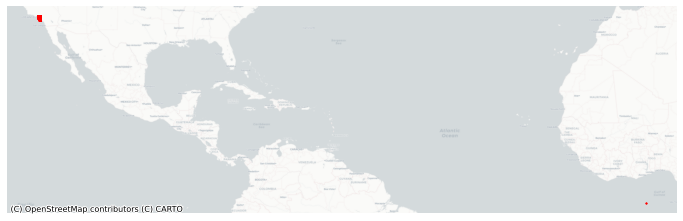

In [9]:
# map it!
ax = arrests.plot(figsize=(12,12),
                  color='red',
                  markersize=1)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


### The 0,0 conundrum
What is that red dot off the coast of Africa? Yes, that is the infamous spatial black hole, the [0,0] coordinate. There can be many reasons why those red dots get lost and find themselves there. No data may default to 0's, null values may be converted to 0's, or a human may have inadvertently entered 0's for unknown locations. Either which way, since these records do not have valid locations, they need to be deleted from our dataframe in order to proceed.

In [10]:
# subset the zero coordinate records
arrests[arrests.lon==0]

,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,descent_cd,...,location,lat,lon,location_1,bkg_date,bkg_time,bgk_location,bkg_loc_cd,crsst,geometry
18173,5951250,BOOKING,2020-06-09T00:00:00.000,0025,06,Hollywood,0665,39,M,O,...,FOUNTAIN,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",2020-06-09T00:00:00.000,0224,HOLLYWOOD,4206,MACCADEN,POINT (0.00000 0.00000)
26039,5921308,BOOKING,2020-04-26T00:00:00.000,1500,19,Mission,1942,25,M,H,...,REGAN FY,0.0,0.0,"{'type': 'Point', 'coordinates': [0, 0]}",2020-04-26T00:00:00.000,1631,VALLEY - JAIL DIV,4279,LAUREL CANYON BL,POINT (0.00000 0.00000)


In [11]:
# drop the unmapped rows
arrests.drop(arrests[arrests.lon==0].index,inplace=True)

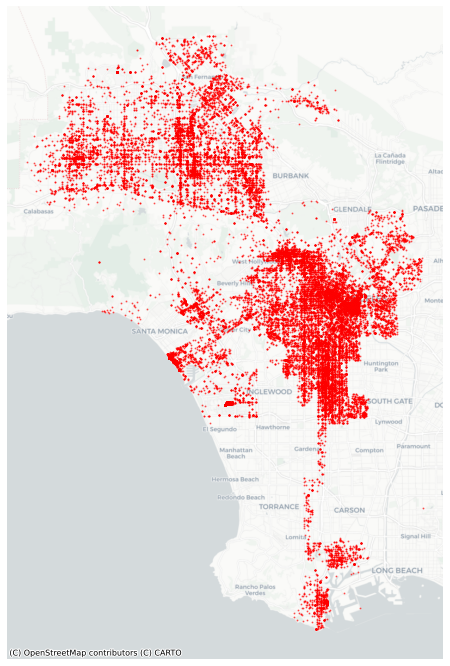

In [12]:
# map it again
ax = arrests.plot(figsize=(12,12),
                  color='red',
                  markersize=1,
                  alpha=0.5)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [13]:
arrests.head()

,rpt_id,report_type,arst_date,time,area,area_desc,rd,age,sex_cd,descent_cd,...,location,lat,lon,location_1,bkg_date,bkg_time,bgk_location,bkg_loc_cd,crsst,geometry
0,6019649,BOOKING,2020-09-26T00:00:00.000,1340,02,Rampart,0269,29,M,B,...,1200 W 7TH ST,34.0515,-118.2658,"{'type': 'Point', 'coordinates': [-118.2658, 3...",2020-09-26T00:00:00.000,1612,METRO - JAIL DIVISION,4273,NaN,POINT (-13165288.634 4035719.316)
1,6019527,BOOKING,2020-09-26T00:00:00.000,0615,14,Pacific,1494,26,M,B,...,400 WORLD WAY WY,33.9420,-118.4095,"{'type': 'Point', 'coordinates': [-118.4095, 3...",2020-09-26T00:00:00.000,0819,PACIFIC,4214,NaN,POINT (-13181285.245 4021016.699)
2,6019650,BOOKING,2020-09-26T00:00:00.000,1250,07,Wilshire,0702,53,M,W,...,SIERRA BONITA,34.0837,-118.3543,"{'type': 'Point', 'coordinates': [-118.3543, 3...",2020-09-26T00:00:00.000,1612,METRO - JAIL DIVISION,4273,MELROSE,POINT (-13175140.409 4040046.436)
3,6019578,BOOKING,2020-09-26T00:00:00.000,0920,15,N Hollywood,1531,41,M,H,...,WHITSETT,34.1758,-118.4052,"{'type': 'Point', 'coordinates': [-118.4052, 3...",2020-09-26T00:00:00.000,1120,VALLEY - JAIL DIV,4279,HATTERAS,POINT (-13180806.571 4052432.169)
4,6019399,BOOKING,2020-09-26T00:00:00.000,0105,01,Central,0163,19,M,W,...,9TH,34.0430,-118.2571,"{'type': 'Point', 'coordinates': [-118.2571, 3...",2020-09-26T00:00:00.000,0225,METRO - JAIL DIVISION,4273,HILL,POINT (-13164320.155 4034577.338)


In [14]:
arrests.loc[10].geometry.x

-13165088.259175705

In [ ]:
arrests.to_file("arrests.geojson", driver='GeoJSON')

In [15]:
import seaborn

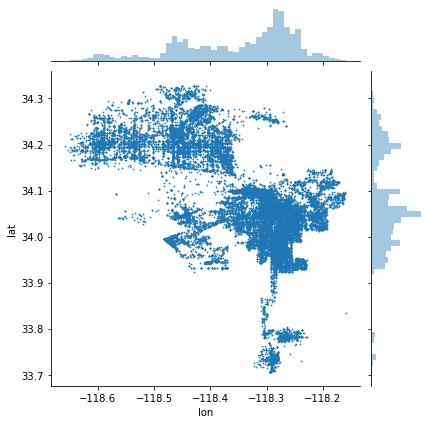

In [16]:
# Generate scatter plot
seaborn.jointplot(x='lon', y='lat', data=arrests, s=0.5);

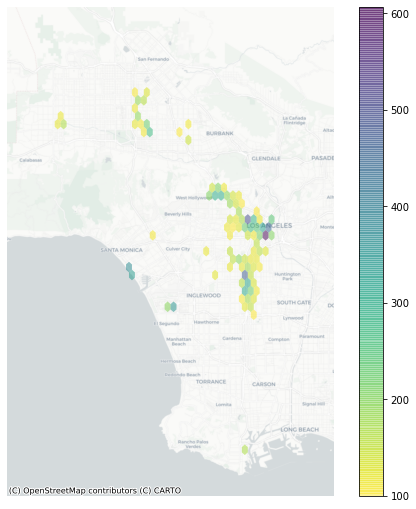

In [17]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Generate and add hexbin with 50 hexagons in each 
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
hb = ax.hexbin(arrests.geometry.x, arrests.geometry.y,
               gridsize=50, linewidths=0, mincnt=100,
               alpha=0.5, cmap='viridis_r')
# ax.axis(data_extent)

# Add colorbar
plt.colorbar(hb)

# Remove axes
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

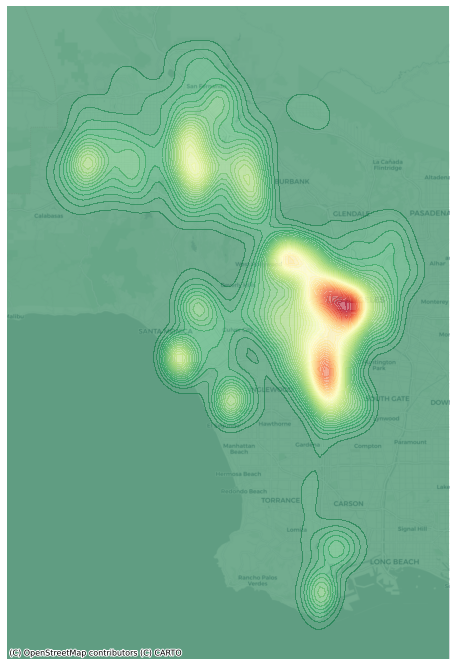

In [18]:
# Set up figure and axis
f, ax = plt.subplots(1, figsize=(12,12))

# Generate and add hexbin with 50 hexagons in each 
# dimension, no borderlines, half transparency,
# and the reverse viridis colormap
# hb = ax.hexbin(arrests.geometry.x, arrests.geometry.y,
#                gridsize=50, linewidths=0, mincnt=100,
#                alpha=0.5, cmap='viridis_r')
# ax.axis(data_extent)
seaborn.kdeplot(arrests.geometry.x, arrests.geometry.y,
                n_levels=50, shade=True, 
                alpha=0.55, cmap='RdYlGn_r')

# Add colorbar
# plt.colorbar(hb)

# Remove axes
ax.set_axis_off()

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

In [19]:
import geoplot as gplt

In [31]:
# neighborhoods from LA Times
neighborhoods = gpd.read_file('http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/la-county-neighborhoods-v5.geojson')

In [32]:
# clean it up
neighborhoods = neighborhoods[['name','geometry']]

#rename columns
neighborhoods.columns=['neighborhood','geometry']

neighborhoods.head ()

,neighborhood,geometry
0,Acton,"MULTIPOLYGON (((-118.20262 34.53899, -118.1894..."
1,Adams-Normandie,"MULTIPOLYGON (((-118.30901 34.03741, -118.3004..."
2,Agoura Hills,"MULTIPOLYGON (((-118.76193 34.16820, -118.7263..."
3,Agua Dulce,"MULTIPOLYGON (((-118.25468 34.55830, -118.2555..."
4,Alhambra,"MULTIPOLYGON (((-118.12175 34.10504, -118.1168..."


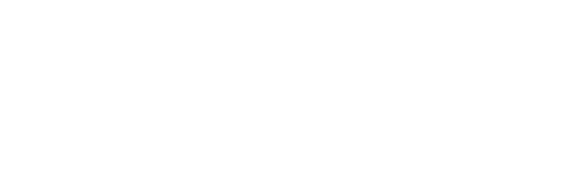

In [33]:
fig,ax = plt.subplots(figsize=(10,5))

gplt.kdeplot(arrests,
    cmap='Reds',
#     projection=proj,
    shade=True, shade_lowest=False, 
    clip=neighborhoods.geometry,
    ax=ax
)

# seaborn.kdeplot(arrests.geometry.x, arrests.geometry.y,
#                 n_levels=50, shade=True, 
#                 alpha=0.55, cmap='RdYlGn_r')

